In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
# import random
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib as mpl

import matplotlib.ticker as ticker
from statistics import median

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [98]:
def get_str_exp_values(str_gene,pop='EUR',minsPgt=3):
    """
    input str-gene pairs and population
    extract the genotypes: sum of alleles output the expression 
    """
    
    chrom=str_gene.split('_')[0]
    pos=int(str_gene.split('-')[0].split('_')[1])
    gene_id=str_gene.split('-')[1]
    
    gt_dir='/storage/yal084/geuvidas_eQTL/ensemble_call/GB_info/'\
        +str(chrom)+'.GB.FORMAT'
    exp_df=pd.read_csv('/storage/yal084/geuvidas_eQTL/normalized_expression/'+pop+'_normalized_and_filtered_hg38.csv',sep='\t')
    exp_df=exp_df[exp_df.gene_id==gene_id]
    
    all_STR=pd.read_csv(gt_dir,sep='\t')
    select_STR=all_STR[all_STR.POS==pos].copy()
    select_STR[select_STR.columns[2:]]=select_STR[select_STR.columns[2:]]. \
                    applymap(lambda x: [int(x.split('/')[0]),int(x.split('/')[1])] if '/' in x else [None,None])
    select_STR=select_STR[['CHROM','POS']+select_STR.columns[2:][select_STR.iloc[0,2:].apply(lambda x: x !=[None,None])].to_list()]
    gt_samples=select_STR.columns[2:][select_STR.iloc[0,2:].apply(lambda x: x !=[None,None])].to_list()
    gt_samples=list(set(gt_samples) & set(exp_df.columns.tolist()))
    select_STR_phased=select_STR[gt_samples].T.rename \
                        (columns={select_STR.index.to_list()[0]:'GT'}).applymap(lambda x: sum(x))
    gt_sum=select_STR_phased.groupby('GT').size()
    gt_ab_3=gt_sum[gt_sum>=minsPgt].index.tolist()
    final_filted_samples=set(select_STR_phased[select_STR_phased.GT.isin(gt_ab_3)].index)
    final_phased_STR=select_STR_phased.loc[final_filted_samples].copy()
    
    return final_phased_STR.values.reshape(-1),exp_df[final_filted_samples].values.reshape(-1)

In [99]:
str_gene = 'chr11_57528484-ENSG00000134809.4'
afr_str, afr_expr = get_str_exp_values(str_gene,pop='AFR')
eur_str, eur_expr = get_str_exp_values(str_gene,pop='EUR')

In [100]:
def GetSummary(gts, exprs):
    gtvals = sorted(list(set(gts)))
    evals = []
    for gtval in gtvals:
        evals.append(np.median([exprs[i] for i in range(len(exprs)) if gts[i]==gtval]))
    return gtvals, evals

afr_str_summ, afr_expr_summ = GetSummary(afr_str, afr_expr)
eur_str_summ, eur_expr_summ = GetSummary(eur_str, eur_expr)

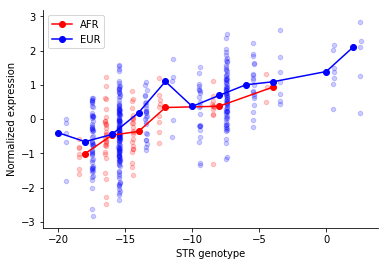

In [101]:
AFR_COLOR = "red"
EUR_COLOR = "blue"

buf = 0.5
def AddNoise(items):
    return [item + np.random.uniform(0, 0.1) for item in items]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(AddNoise([item-buf for item in afr_str]),afr_expr,color=AFR_COLOR, alpha=0.2,s=20) 
ax.plot(afr_str_summ, afr_expr_summ, color=AFR_COLOR, marker="o", label="AFR")
ax.scatter(AddNoise([item+buf for item in eur_str]),eur_expr,color=EUR_COLOR, alpha=0.2,s=20) 
ax.plot(eur_str_summ, eur_expr_summ, color=EUR_COLOR, marker="o", label="EUR")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.legend()
ax.set_xlabel("STR genotype")
ax.set_ylabel("Normalized expression");
fig.savefig("%s.pdf"%str_gene)